In [122]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)
library(car)
library(ggplot2)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(ggeffects)


filename <- 'generated/num_of_review_comments.csv'

effectiveCommentsData <- read.csv(file=filename, header=TRUE, sep=",")

effectiveCommentsData$LanguageType = as.factor(effectiveCommentsData$LanguageType)

effectiveCommentsData$EffectiveComments = log(effectiveCommentsData$EffectiveComments + 1)
effectiveCommentsData$Additions = log(effectiveCommentsData$Additions + 1)
effectiveCommentsData$Deletions = log(effectiveCommentsData$Deletions + 1)
effectiveCommentsData$TotalReviewComments = log(effectiveCommentsData$TotalReviewComments + 1)
effectiveCommentsData$TotalReviewCommentThreads = log(effectiveCommentsData$TotalReviewCommentThreads + 1)
effectiveCommentsData$GeneralComments = log(effectiveCommentsData$GeneralComments + 1)
effectiveCommentsData$Commits = log(effectiveCommentsData$Commits + 1)
effectiveCommentsData$Assignees = log(effectiveCommentsData$Assignees + 1)
effectiveCommentsData$ChangedFiles = log(effectiveCommentsData$ChangedFiles + 1)
effectiveCommentsData$PrOpenedDaysAfterProjectStart = log(effectiveCommentsData$PrOpenedDaysAfterProjectStart + 1)
effectiveCommentsData$NumOfUniqueUsers = log(effectiveCommentsData$NumOfUniqueUsers + 1)
effectiveCommentsData$PRsOpened = log(effectiveCommentsData$PRsOpened + 1)
effectiveCommentsData$TotalBuilds = log(effectiveCommentsData$TotalBuilds + 1)
effectiveCommentsData$AdditionsAfterCreate = log(effectiveCommentsData$AdditionsAfterCreate + 1)
effectiveCommentsData$CommitsAfterCreate = log(effectiveCommentsData$CommitsAfterCreate + 1)
effectiveCommentsData$DeletionsAfterCreate = log(effectiveCommentsData$DeletionsAfterCreate + 1)

summary(effectiveCommentsData)

 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.0000    Min.   :0.0000      Min.   :0.0000           
 1st Qu.:0.0000    1st Qu.:0.0000      1st Qu.:0.0000           
 Median :0.0000    Median :0.0000      Median :0.0000           
 Mean   :0.0776    Mean   :0.3007      Mean   :0.2776           
 3rd Qu.:0.0000    3rd Qu.:0.0000      3rd Qu.:0.0000           
 Max.   :5.7462    Max.   :6.0426      Max.   :6.0039           
                                                                
 ShareReviewComments GeneralComments  GeneralCommentsDiscussingBuild
 Min.   :  0.00      Min.   :0.0000   Min.   :0                     
 1st Qu.:  0.00      1st Qu.:0.0000   1st Qu.:0                     
 Median :  0.00      Median :0.6931   Median :0                     
 Mean   : 10.44      Mean   :0.8904   Mean   :0                     
 3rd Qu.:  0.00      3rd Qu.:1.3863   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.9431   Max.   :0                   

In [144]:
hasEffectiveComments <- sqldf("select *
                      from 'effectiveCommentsData' 
                      where EffectiveComments > 0")

print(nrow(hasEffectiveComments))

summary(hasEffectiveComments)

no_linter_static = nrow(subset(hasEffectiveComments, Linter == 'False' & LanguageType == 'static'))
linter_static = nrow(subset(hasEffectiveComments, Linter == 'True' & LanguageType == 'static'))

no_linter_dynamic = nrow(subset(hasEffectiveComments, Linter == 'False' & LanguageType == 'dynamic'))
linter_dynamic = nrow(subset(hasEffectiveComments, Linter == 'True' & LanguageType == 'dynamic'))


print(no_linter_static)
print(linter_static)

print(no_linter_dynamic)
print(linter_dynamic)

[1] 19373


 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.6931    Min.   :0.6931      Min.   :0.6931           
 1st Qu.:0.6931    1st Qu.:1.0986      1st Qu.:1.0986           
 Median :1.0986    Median :1.7918      Median :1.6094           
 Mean   :1.3090    Mean   :1.9286      Mean   :1.7871           
 3rd Qu.:1.6094    3rd Qu.:2.5649      3rd Qu.:2.3979           
 Max.   :5.7462    Max.   :6.0426      Max.   :5.8861           
                                                                
 ShareReviewComments GeneralComments GeneralCommentsDiscussingBuild
 Min.   :  0.9132    Min.   :0.000   Min.   :0                     
 1st Qu.: 36.3636    1st Qu.:1.099   1st Qu.:0                     
 Median : 60.0000    Median :1.609   Median :0                     
 Mean   : 58.3475    Mean   :1.621   Mean   :0                     
 3rd Qu.: 80.0000    3rd Qu.:2.197   3rd Qu.:0                     
 Max.   :100.0000    Max.   :6.136   Max.   :0                     
    

[1] 1959
[1] 4480
[1] 4565
[1] 5432


# Hurdle

First we make a hurdle model to determine whether we can detect zero pull requests vs non zero pull requests. We pick an equal amount of pull requests with zero and non zero effective comments and then build a linear regression. 

In [178]:
zerosdf <- sqldf('select * from "effectiveCommentsData" where EffectiveComments = 0 and LanguageType != "unk"')

sampledZerosdf <- zerosdf[sample(nrow(zerosdf), nrow(sqldf('select * from hasEffectiveComments where LanguageType != "unk"'))),]

combined <- rbind(sampledZerosdf, sqldf('select * from hasEffectiveComments where LanguageType != "unk"'))

baseHurdleModel = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModel)
r.squaredGLMM(baseHurdleModel)
vif(baseHurdleModel)
anova(baseHurdleModel)


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + TotalReviewCommentThreads + 
    GeneralComments + CommitsAfterCreate + LanguageType + IsAfter, 
    family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2491  -0.2161  -0.0053   0.2491   2.5827  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.67379    0.23124 -20.212  < 2e-16 ***
Additions                     -0.03362    0.01823  -1.844 0.065168 .  
Deletions                     -0.14726    0.01765  -8.345  < 2e-16 ***
IsMergedTrue                   0.44559    0.05430   8.206 2.30e-16 ***
Commits                       -0.61602    0.05656 -10.891  < 2e-16 ***
LinterTrue                     0.03780    0

R2m       R2c 
0.8576726 0.8576726

Additions                     Deletions 
                     3.170073                      2.494463 
                     IsMerged                       Commits 
                     1.137402                      2.479145 
                       Linter                      Coverage 
                     1.052936                      1.119843 
                    Assignees                  ChangedFiles 
                     1.041258                      3.582144 
             NumOfUniqueUsers                     PRsOpened 
                     2.574678                      3.013505 
                  TotalBuilds                NewContributor 
                     3.140352                      1.766267 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.877195                      1.908035 
    TotalReviewCommentThreads               GeneralComments 
                     1.292641                      2.495760 
           CommitsAfterCreate                  LanguageType 
                     2.249683                      1.197471 
                      IsAfter 
                     3.808657

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,32871,45570.27
Additions,1,3641.8920767,32870,41928.38
Deletions,1,161.2777607,32869,41767.10
IsMerged,1,7.2943937,32868,41759.80
Commits,1,7330.4176951,32867,34429.39
Linter,1,61.5991405,32866,34367.79
Coverage,1,7.5250370,32865,34360.26
Assignees,1,170.4652208,32864,34189.80
ChangedFiles,1,171.8098578,32863,34017.99
NumOfUniqueUsers,1,6967.4350441,32862,27050.55



Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + TotalReviewCommentThreads + 
    GeneralComments + CommitsAfterCreate + LanguageType * IsAfter, 
    family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2508  -0.2160  -0.0053   0.2490   2.5805  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -4.66713    0.23161 -20.151  < 2e-16 ***
Additions                      -0.03363    0.01823  -1.844 0.065172 .  
Deletions                      -0.14714    0.01765  -8.337  < 2e-16 ***
IsMergedTrue                    0.44487    0.05432   8.190 2.62e-16 ***
Commits                        -0.61658    0.05658 -10.898  < 2e-16 ***
LinterTrue                      0.037

R2m       R2c 
0.8576759 0.8576759

Additions                     Deletions 
                     3.170199                      2.495270 
                     IsMerged                       Commits 
                     1.138119                      2.480650 
                       Linter                      Coverage 
                     1.052939                      1.120126 
                    Assignees                  ChangedFiles 
                     1.041821                      3.583233 
             NumOfUniqueUsers                     PRsOpened 
                     2.575998                      3.014406 
                  TotalBuilds                NewContributor 
                     3.152088                      1.766344 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.882888                      1.908107 
    TotalReviewCommentThreads               GeneralComments 
                     1.293096                      2.496538 
           CommitsAfterCreate                  LanguageType 
                     2.249976                      2.573305 
                      IsAfter          LanguageType:IsAfter 
                     4.761741                      3.129395

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,32871,45570.27
Additions,1,3641.8920767,32870,41928.38
Deletions,1,161.2777607,32869,41767.10
IsMerged,1,7.2943937,32868,41759.80
Commits,1,7330.4176951,32867,34429.39
Linter,1,61.5991405,32866,34367.79
Coverage,1,7.5250370,32865,34360.26
Assignees,1,170.4652208,32864,34189.80
ChangedFiles,1,171.8098578,32863,34017.99
NumOfUniqueUsers,1,6967.4350441,32862,27050.55


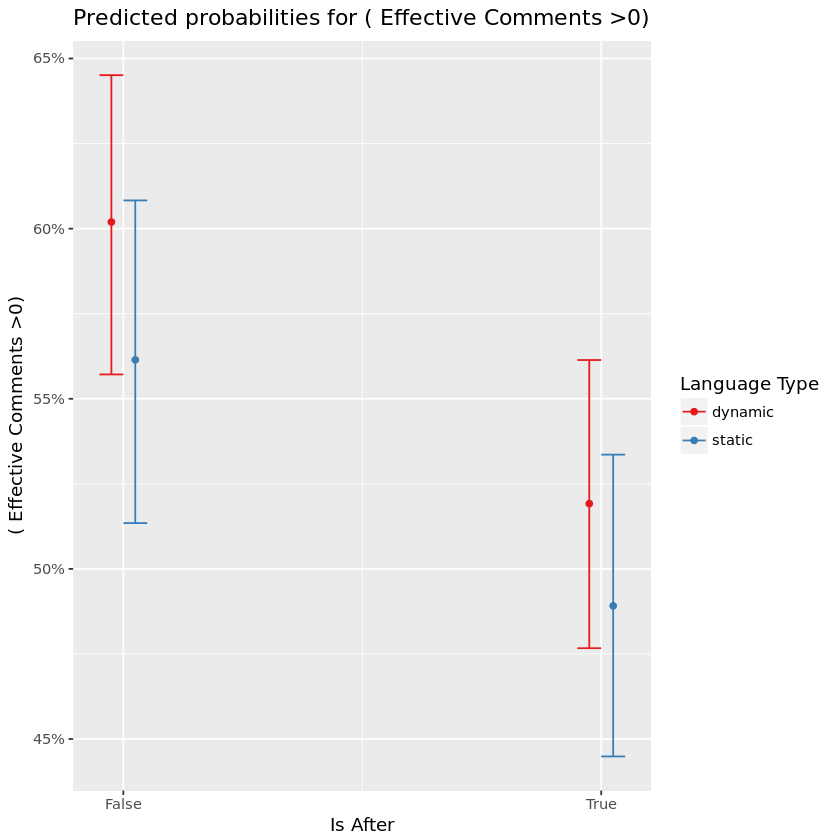

In [179]:
baseHurdleModelInteraction = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType *
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModelInteraction)
r.squaredGLMM(baseHurdleModelInteraction)
vif(baseHurdleModelInteraction)
anova(baseHurdleModelInteraction)

plot_model(baseHurdleModelInteraction, type="pred", terms=c('IsAfter', 'LanguageType'))


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + TotalReviewCommentThreads + 
    GeneralComments + CommitsAfterCreate + LanguageType + Coverage * 
    IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2546  -0.2164  -0.0053   0.2492   2.5914  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.64370    0.23301 -19.929  < 2e-16 ***
Additions                     -0.03336    0.01823  -1.829 0.067333 .  
Deletions                     -0.14725    0.01765  -8.345  < 2e-16 ***
IsMergedTrue                   0.44302    0.05435   8.151 3.62e-16 ***
Commits                       -0.61552    0.05657 -10.881  < 2e-16 ***
LinterTrue                     0.03640    0

R2m      R2c 
0.857694 0.857694

Additions                     Deletions 
                     3.170839                      2.494681 
                     IsMerged                       Commits 
                     1.139652                      2.479263 
                       Linter                     Assignees 
                     1.053737                      1.042027 
                 ChangedFiles              NumOfUniqueUsers 
                     3.581811                      2.575373 
                    PRsOpened                   TotalBuilds 
                     3.019345                      3.148267 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.767544                      1.877301 
                 FromOutsider     TotalReviewCommentThreads 
                     1.908757                      1.292661 
              GeneralComments            CommitsAfterCreate 
                     2.497410                      2.250969 
                 LanguageType                      Coverage 
                     1.198156                      2.511410 
                      IsAfter              Coverage:IsAfter 
                     4.478322                      3.328497

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,32871,45570.27
Additions,1,3.641892e+03,32870,41928.38
Deletions,1,1.612778e+02,32869,41767.10
IsMerged,1,7.294394e+00,32868,41759.80
Commits,1,7.330418e+03,32867,34429.39
Linter,1,6.159914e+01,32866,34367.79
Assignees,1,1.616033e+02,32865,34206.18
ChangedFiles,1,1.716736e+02,32864,34034.51
NumOfUniqueUsers,1,6.982029e+03,32863,27052.48
PRsOpened,1,6.040236e-02,32862,27052.42


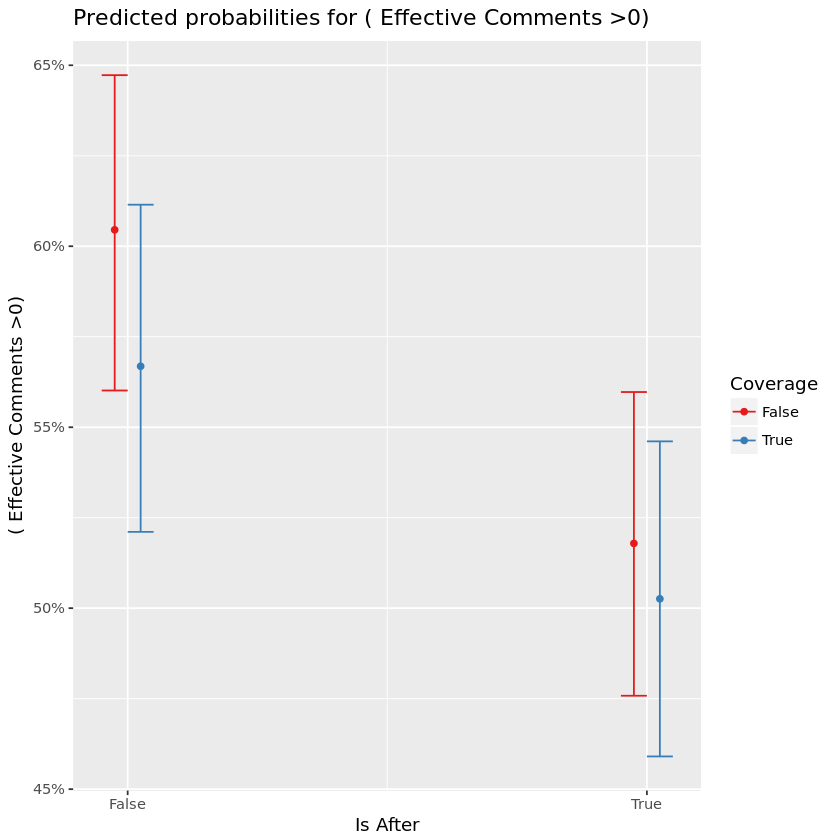

In [180]:
hurdleModelInteractionCoverage = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
                                         Coverage*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverage)
r.squaredGLMM(hurdleModelInteractionCoverage)
vif(hurdleModelInteractionCoverage)
anova(hurdleModelInteractionCoverage)

plot_model(hurdleModelInteractionCoverage, type="pred", terms=c('IsAfter', 'Coverage'))


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + TotalReviewCommentThreads + 
    GeneralComments + CommitsAfterCreate + LanguageType + Linter * 
    IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2445  -0.2165  -0.0054   0.2496   2.5691  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.73159    0.23346 -20.267  < 2e-16 ***
Additions                     -0.03346    0.01824  -1.835  0.06653 .  
Deletions                     -0.14684    0.01765  -8.321  < 2e-16 ***
IsMergedTrue                   0.44223    0.05432   8.141 3.93e-16 ***
Commits                       -0.61750    0.05657 -10.916  < 2e-16 ***
CoverageTrue                  -0.09893    0

R2m       R2c 
0.8577151 0.8577151

Additions                     Deletions 
                     3.170053                      2.495053 
                     IsMerged                       Commits 
                     1.138430                      2.478506 
                     Coverage                     Assignees 
                     1.120048                      1.041325 
                 ChangedFiles              NumOfUniqueUsers 
                     3.582216                      2.575199 
                    PRsOpened                   TotalBuilds 
                     3.011931                      3.137583 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.765903                      1.876308 
                 FromOutsider     TotalReviewCommentThreads 
                     1.908432                      1.292690 
              GeneralComments            CommitsAfterCreate 
                     2.500070                      2.251030 
                 LanguageType                        Linter 
                     1.196992                      2.438898 
                      IsAfter                Linter:IsAfter 
                     5.432532                      3.913925

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,32871,45570.27
Additions,1,3641.8920767,32870,41928.38
Deletions,1,161.2777607,32869,41767.10
IsMerged,1,7.2943937,32868,41759.80
Commits,1,7330.4176951,32867,34429.39
Coverage,1,8.3964628,32866,34420.99
Assignees,1,159.5478448,32865,34261.44
ChangedFiles,1,173.8854677,32864,34087.56
NumOfUniqueUsers,1,7032.3685741,32863,27055.19
PRsOpened,1,0.2493969,32862,27054.94


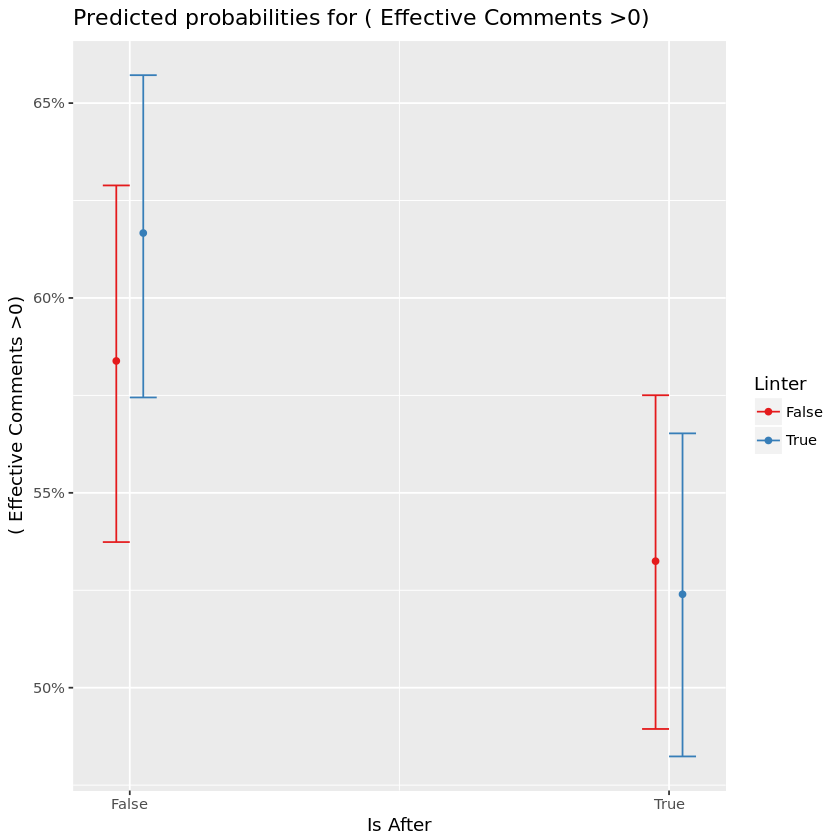

In [181]:
hurdleModelInteractionLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
                                         Linter*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLinter)
r.squaredGLMM(hurdleModelInteractionLinter)
vif(hurdleModelInteractionLinter)
anova(hurdleModelInteractionLinter)

plot_model(hurdleModelInteractionLinter, type="pred", terms=c('IsAfter', 'Linter'))


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    CommitsAfterCreate + LanguageType + Coverage * Linter * IsAfter, 
    family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2602  -0.2170  -0.0053   0.2481   2.6168  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -4.80601    0.23763 -20.224  < 2e-16 ***
Additions                           -0.03219    0.01826  -1.763 0.077917 .  
Deletions                           -0.14709    0.01767  -8.324  < 2e-16 ***
IsMergedTrue                         0.43592    0.05439   8.015 1.10e-15 ***
Commits                             -0.61932    0.05673 -10.917  < 2e-16 ***
Assigne

R2m       R2c 
0.8579754 0.8579754

Additions                     Deletions 
                     3.172350                      2.496095 
                     IsMerged                       Commits 
                     1.141191                      2.482065 
                    Assignees                  ChangedFiles 
                     1.045075                      3.582389 
             NumOfUniqueUsers                     PRsOpened 
                     2.573015                      3.025808 
                  TotalBuilds                NewContributor 
                     3.148760                      1.767917 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.881760                      1.933402 
    TotalReviewCommentThreads               GeneralComments 
                     1.297231                      2.502494 
           CommitsAfterCreate                  LanguageType 
                     2.256099                      1.227855 
                     Coverage                        Linter 
                     6.471917                      4.478995 
                      IsAfter               Coverage:Linter 
                     7.382492                      8.455592 
             Coverage:IsAfter                Linter:IsAfter 
                     8.470638                      7.267851 
      Coverage:Linter:IsAfter 
                     9.868540

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,32871,45570.27
Additions,1,3641.8920767,32870,41928.38
Deletions,1,161.2777607,32869,41767.10
IsMerged,1,7.2943937,32868,41759.80
Commits,1,7330.4176951,32867,34429.39
Assignees,1,150.4742584,32866,34278.91
ChangedFiles,1,173.7212971,32865,34105.19
NumOfUniqueUsers,1,7048.0764315,32864,27057.11
PRsOpened,1,0.1815631,32863,27056.93
TotalBuilds,1,351.9134716,32862,26705.02


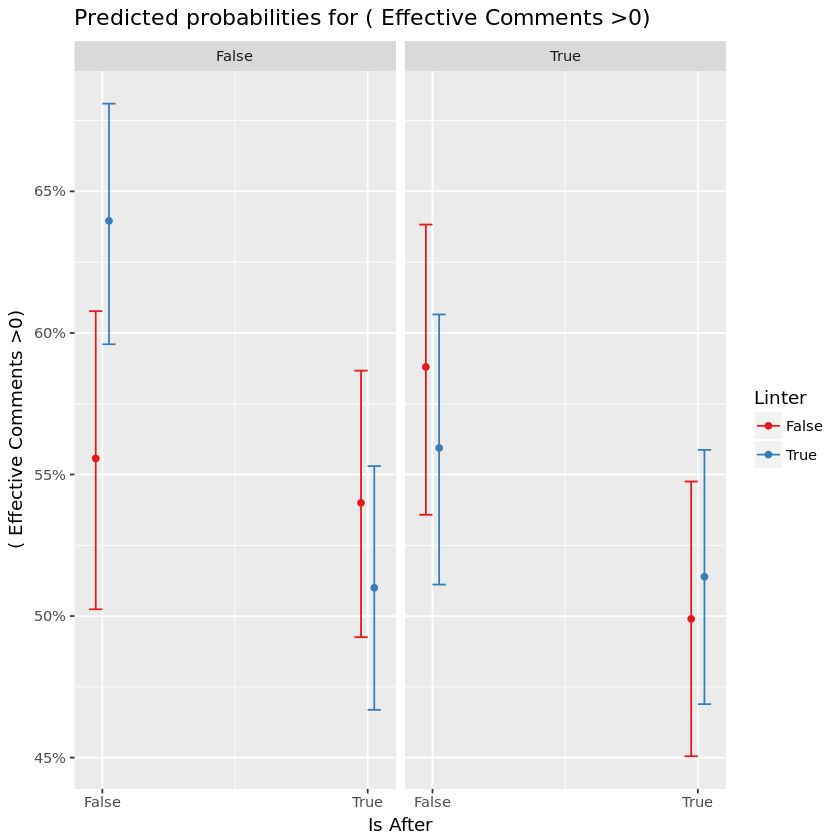

In [182]:
hurdleModelInteractionCoverageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
                                           Coverage*
                                         Linter*
            IsAfter ,
          data=combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverageLinter)
r.squaredGLMM(hurdleModelInteractionCoverageLinter)
vif(hurdleModelInteractionCoverageLinter)
anova(hurdleModelInteractionCoverageLinter)

plot_model(hurdleModelInteractionCoverageLinter, type="pred", terms=c('IsAfter', 'Linter', 'Coverage'))


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    CommitsAfterCreate + Coverage + LanguageType * Linter * IsAfter, 
    family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2405  -0.2164  -0.0054   0.2490   2.5682  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -4.72664    0.23737 -19.912  < 2e-16
Additions                                 -0.03352    0.01824  -1.838  0.06607
Deletions                                 -0.14726    0.01766  -8.338  < 2e-16
IsMergedTrue                               0.44363    0.05441   8.154 3.52e-16
Commits                                   -0.61961    0.05662 -10.944  < 2

R2m       R2c 
0.8577743 0.8577743

Additions                     Deletions 
                     3.167611                      2.497325 
                     IsMerged                       Commits 
                     1.140956                      2.480692 
                    Assignees                  ChangedFiles 
                     1.046172                      3.581794 
             NumOfUniqueUsers                     PRsOpened 
                     2.576410                      3.015309 
                  TotalBuilds                NewContributor 
                     3.149043                      1.766468 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.889068                      1.916305 
    TotalReviewCommentThreads               GeneralComments 
                     1.294227                      2.503069 
           CommitsAfterCreate                      Coverage 
                     2.251913                      1.158676 
                 LanguageType                        Linter 
                     7.423846                      3.885024 
                      IsAfter           LanguageType:Linter 
                     6.814544                      9.318622 
         LanguageType:IsAfter                Linter:IsAfter 
                     8.936596                      6.387424 
  LanguageType:Linter:IsAfter 
                    10.444594

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,32871,45570.27
Additions,1,3641.8920767,32870,41928.38
Deletions,1,161.2777607,32869,41767.10
IsMerged,1,7.2943937,32868,41759.80
Commits,1,7330.4176951,32867,34429.39
Assignees,1,150.4742584,32866,34278.91
ChangedFiles,1,173.7212971,32865,34105.19
NumOfUniqueUsers,1,7048.0764315,32864,27057.11
PRsOpened,1,0.1815631,32863,27056.93
TotalBuilds,1,351.9134716,32862,26705.02


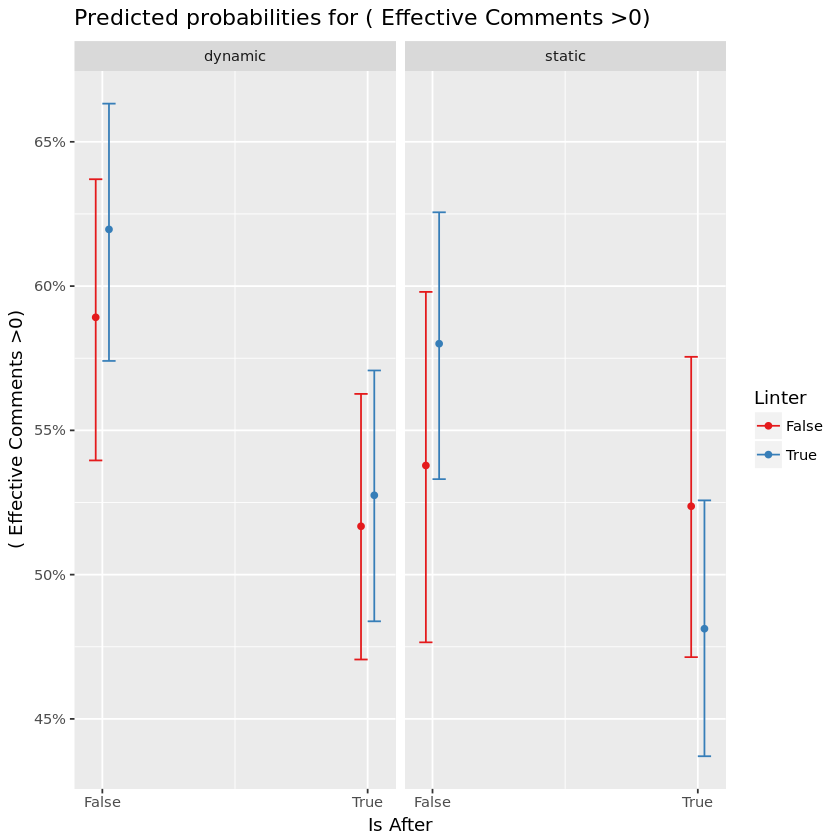

In [183]:
hurdleModelInteractionLanguageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            Coverage +
            LanguageType *
            Linter*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageLinter)
r.squaredGLMM(hurdleModelInteractionLanguageLinter)
vif(hurdleModelInteractionLanguageLinter)
anova(hurdleModelInteractionLanguageLinter)

plot_model(hurdleModelInteractionLanguageLinter, type="pred", terms=c('IsAfter', 'Linter', 'LanguageType'))


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    CommitsAfterCreate + Linter + LanguageType * Coverage * IsAfter, 
    family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2492  -0.2163  -0.0053   0.2493   2.6172  

Coefficients:
                                            Estimate Std. Error z value
(Intercept)                                 -4.58605    0.23494 -19.520
Additions                                   -0.03447    0.01827  -1.887
Deletions                                   -0.14674    0.01765  -8.312
IsMergedTrue                                 0.44191    0.05442   8.120
Commits                                     -0.61631    0.05668 -10.873
Assignees                            

R2m      R2c 
0.857886 0.857886

Additions                     Deletions 
                     3.179097                      2.493711 
                     IsMerged                       Commits 
                     1.141898                      2.486384 
                    Assignees                  ChangedFiles 
                     1.046792                      3.585498 
             NumOfUniqueUsers                     PRsOpened 
                     2.578416                      3.022924 
                  TotalBuilds                NewContributor 
                     3.173503                      1.768174 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.892789                      1.910307 
    TotalReviewCommentThreads               GeneralComments 
                     1.294672                      2.498292 
           CommitsAfterCreate                        Linter 
                     2.256486                      1.086706 
                 LanguageType                      Coverage 
                     4.374128                      4.149862 
                      IsAfter         LanguageType:Coverage 
                     7.062778                      4.967977 
         LanguageType:IsAfter              Coverage:IsAfter 
                     5.689783                      5.727880 
LanguageType:Coverage:IsAfter 
                     5.243479

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,32871,45570.27
Additions,1,3641.8920767,32870,41928.38
Deletions,1,161.2777607,32869,41767.10
IsMerged,1,7.2943937,32868,41759.80
Commits,1,7330.4176951,32867,34429.39
Assignees,1,150.4742584,32866,34278.91
ChangedFiles,1,173.7212971,32865,34105.19
NumOfUniqueUsers,1,7048.0764315,32864,27057.11
PRsOpened,1,0.1815631,32863,27056.93
TotalBuilds,1,351.9134716,32862,26705.02


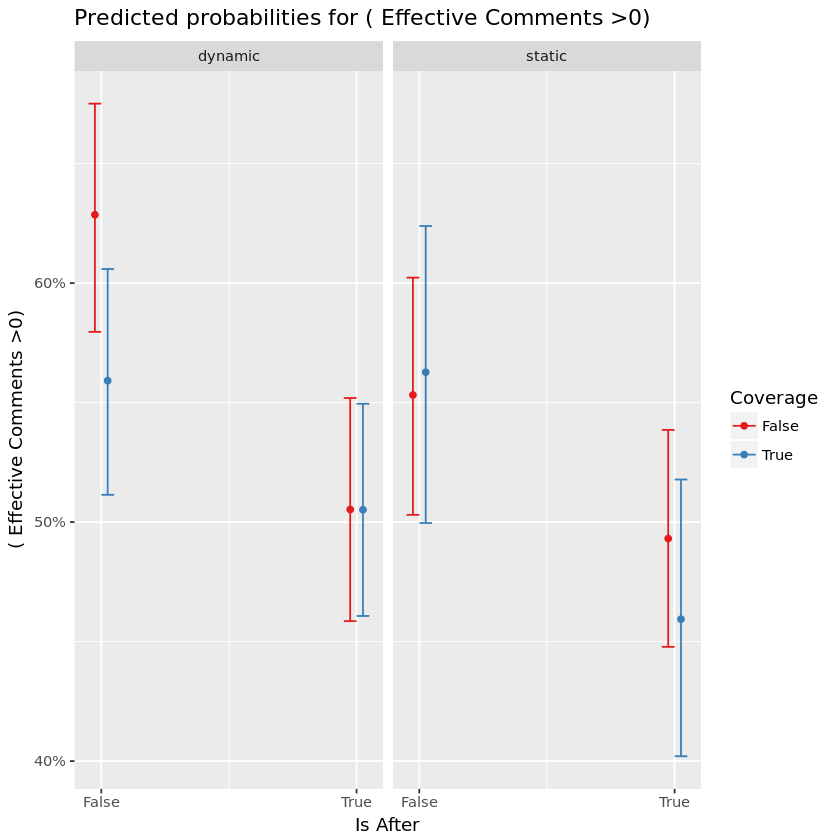

In [184]:
hurdleModelInteractionLanguageCoverage = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            Linter +
            LanguageType *
            Coverage*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageCoverage)
r.squaredGLMM(hurdleModelInteractionLanguageCoverage)
vif(hurdleModelInteractionLanguageCoverage)
anova(hurdleModelInteractionLanguageCoverage)

plot_model(hurdleModelInteractionLanguageCoverage, type="pred", terms=c('IsAfter', 'Coverage', 'LanguageType'))


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    CommitsAfterCreate + LanguageType * Linter * Coverage + IsAfter, 
    family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2471  -0.2160  -0.0053   0.2487   2.5974  

Coefficients:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                                -4.76886    0.23759 -20.071  < 2e-16
Additions                                  -0.03392    0.01826  -1.858 0.063216
Deletions                                  -0.14807    0.01766  -8.384  < 2e-16
IsMergedTrue                                0.44925    0.05440   8.258  < 2e-16
Commits                                    -0.61554    0.05667 -10.86

R2m      R2c 
0.857773 0.857773

Additions                     Deletions 
                     3.178120                      2.497139 
                     IsMerged                       Commits 
                     1.140869                      2.485611 
                    Assignees                  ChangedFiles 
                     1.054615                      3.585206 
             NumOfUniqueUsers                     PRsOpened 
                     2.576101                      3.026120 
                  TotalBuilds                NewContributor 
                     3.152782                      1.768265 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.892096                      1.930571 
    TotalReviewCommentThreads               GeneralComments 
                     1.297581                      2.497453 
           CommitsAfterCreate                  LanguageType 
                     2.259005                      4.673117 
                       Linter                      Coverage 
                     4.110309                      4.082171 
                      IsAfter           LanguageType:Linter 
                     3.821974                      6.501409 
        LanguageType:Coverage               Linter:Coverage 
                    11.202663                      5.981847 
 LanguageType:Linter:Coverage 
                    12.930074

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,32871,45570.27
Additions,1,3641.8920767,32870,41928.38
Deletions,1,161.2777607,32869,41767.10
IsMerged,1,7.2943937,32868,41759.80
Commits,1,7330.4176951,32867,34429.39
Assignees,1,150.4742584,32866,34278.91
ChangedFiles,1,173.7212971,32865,34105.19
NumOfUniqueUsers,1,7048.0764315,32864,27057.11
PRsOpened,1,0.1815631,32863,27056.93
TotalBuilds,1,351.9134716,32862,26705.02


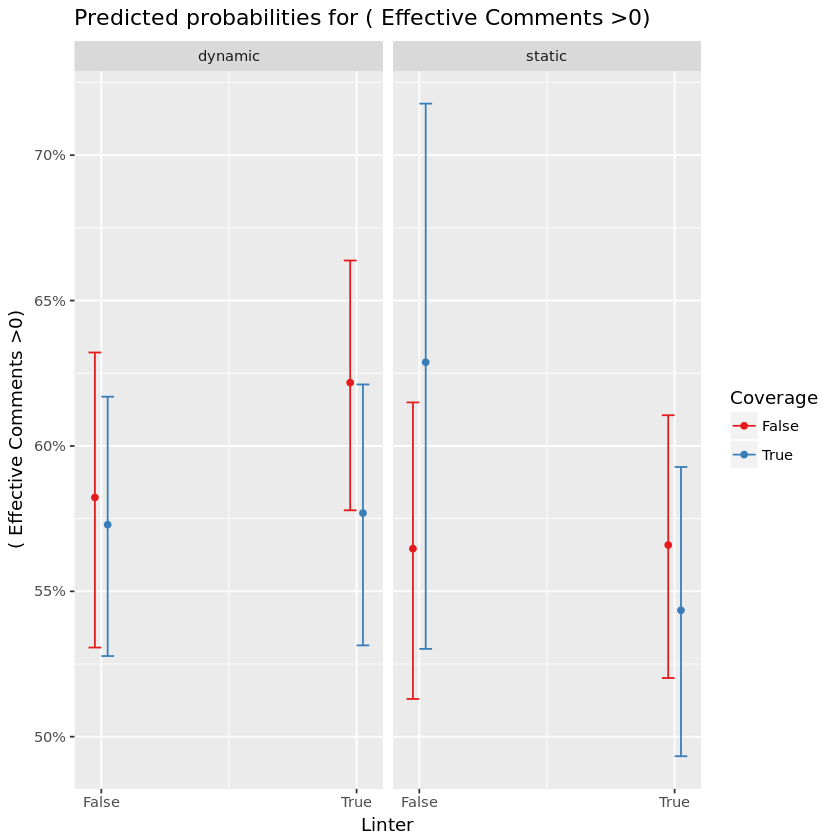

In [185]:
hurdleModelInteractionLanguageCoverageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType *
            Linter*
            Coverage+
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageCoverageLinter)
r.squaredGLMM(hurdleModelInteractionLanguageCoverageLinter)
vif(hurdleModelInteractionLanguageCoverageLinter)
anova(hurdleModelInteractionLanguageCoverageLinter)

plot_model(hurdleModelInteractionLanguageCoverageLinter, type="pred", terms=c('Linter', 'Coverage', 'LanguageType'))

In [125]:
executeLmOnData <- function(formula, data) {
    model = lm(formula ,
          data= data)
    print(summary(model))
    #r.squaredGLMM(model)
    print(vif(model))
    print(anova(model))
    
    return(model)
}

In [126]:
baseModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.63207 -0.22288  0.04225  0.25671  1.91025 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.2711180  0.0350748   7.730 1.13e-14 ***
Additions                      0.0239531  0.0025196   9.507  < 2e-16 ***
Deletions                     -0.0589162  0.0022656 -26.005  < 2e-16 ***
IsMergedTrue                   0.0180223  0.0081578   2.209  0.02717 *  
Assignees                     -0.0372921  0.0137702  -2.708  0.00677 ** 
LinterTrue                    -0.0202363  0.0065702  -3.080  0.00207 ** 
CoverageTrue                  -0.0008161  0.0066932  -0.122  0.90295    
ChangedFiles                   0.0115472  0.0055400   2.084  0.03714 *  
NumOfUniqueUsers              -0.0491065  0.0122808  -3.999 6.39e-05 ***
PRsOpened                     -0.0116624  0.0027408  -4.255 2.10e-05 ***
TotalBuilds                    0.078

# Language type

This cell introduces language type (dynamic / static / unk) to the linear model. This shows a very small increase in the accuracy of the model.

Commits, additions and deletions after create are not included because of high vif scores. 

In [132]:
ltypeModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
                IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
")
        )


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.61396 -0.23172  0.04534  0.26412  1.93189 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.292548   0.038746   7.550 4.57e-14 ***
Additions                      0.022599   0.002839   7.962 1.81e-15 ***
Deletions                     -0.059859   0.002517 -23.786  < 2e-16 ***
IsMergedTrue                   0.013488   0.008933   1.510 0.131067    
Assignees                     -0.046068   0.015486  -2.975 0.002935 ** 
LinterTrue                    -0.005190   0.007518  -0.690 0.489957    
CoverageTrue                   0.002169   0.007726   0.281 0.778969    
ChangedFiles                   0.017073   0.006213   2.748 0.006002 ** 
NumOfUniqueUsers              -0.046473   0.013732  -3.384 0.000715 ***
PRsOpened                     -0.011655   0.003101  -3.758 0.000172 ***
TotalBuilds                    0.084446   0.006

## Language type as interaction effect

Adding in language type as in interaction effect with IsAfter does not appear to have any effect on the accuracy of the model. 


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.61087 -0.23310  0.04627  0.26389  1.93953 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     0.295579   0.038803   7.617 2.73e-14 ***
Additions                       0.022535   0.002839   7.938 2.18e-15 ***
LinterTrue                     -0.005174   0.007518  -0.688 0.491324    
CoverageTrue                    0.002277   0.007726   0.295 0.768245    
Deletions                      -0.059849   0.002517 -23.782  < 2e-16 ***
IsMergedTrue                    0.013268   0.008934   1.485 0.137525    
Assignees                      -0.045582   0.015489  -2.943 0.003256 ** 
ChangedFiles                    0.017070   0.006213   2.748 0.006011 ** 
NumOfUniqueUsers               -0.047073   0.013738  -3.426 0.000613 ***
PRsOpened                      -0.011456   0.003104  -3.690 0.000225 ***
TotalBuilds                     0.08

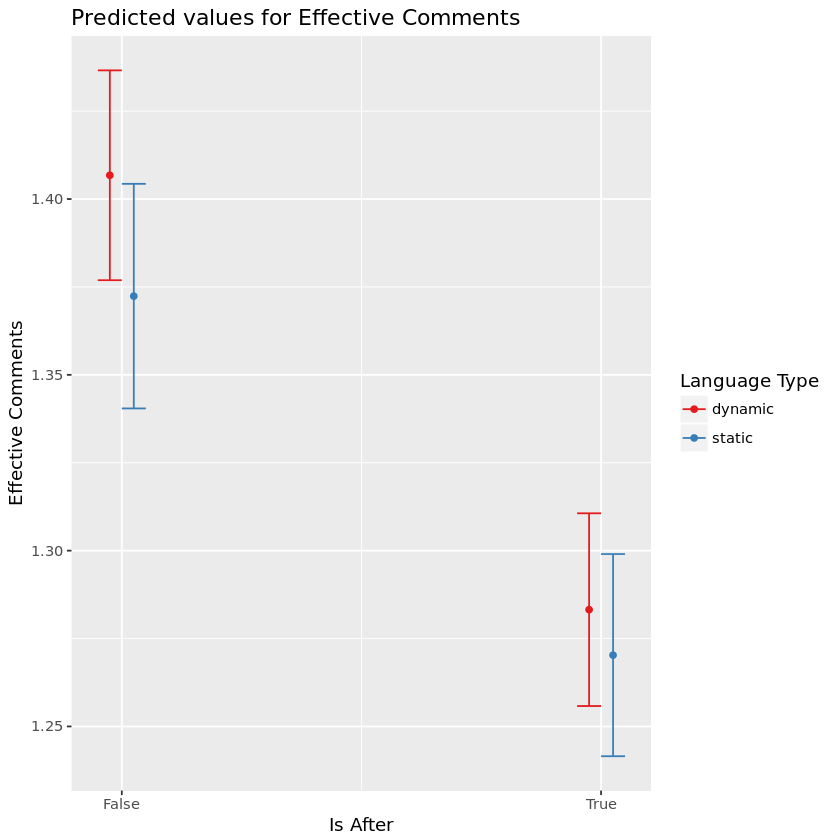

In [128]:
ltypeInteraction <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Linter +
            Coverage +
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType *
            IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
"))

plot_model(ltypeInteraction, type="pred", terms=c('IsAfter', 'LanguageType'))

# Dynamic languages

In [102]:
dynModel <- executeLmOnData(
           EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType = 'dynamic'
"))


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.47897 -0.23527  0.04653  0.26690  1.69064 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.117174   0.049913   2.348   0.0189 *  
Additions                      0.020670   0.003554   5.815 6.24e-09 ***
Deletions                     -0.061796   0.003254 -18.991  < 2e-16 ***
IsMergedTrue                   0.013615   0.010943   1.244   0.2135    
Commits                        0.062772   0.007736   8.114 5.47e-16 ***
Assignees                     -0.045501   0.019634  -2.317   0.0205 *  
ChangedFiles                   0.009831   0.008206   1.198   0.2309    
NumOfUniqueUsers              -0.020997   0.017800  -1.180   0.2382    
PRsOpened                     -0.009966   0.004047  -2.463   0.0138 *  
TotalBuilds                    0.050499   0.009167   5.509 3.71e-08 ***
NewContributorTrue            -0.009742   0.015

# Static languages

In [103]:
staticModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType = 'static'
"))


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.34269 -0.24661  0.04454  0.26158  1.95525 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.392105   0.066140   5.928 3.22e-09 ***
Additions                      0.016867   0.004690   3.597 0.000325 ***
Deletions                     -0.055091   0.003985 -13.825  < 2e-16 ***
IsMergedTrue                   0.023803   0.015599   1.526 0.127070    
Commits                        0.058329   0.008901   6.553 6.08e-11 ***
Assignees                     -0.072742   0.025972  -2.801 0.005114 ** 
ChangedFiles                   0.010580   0.009953   1.063 0.287817    
NumOfUniqueUsers              -0.065165   0.021495  -3.032 0.002443 ** 
PRsOpened                     -0.010346   0.004954  -2.088 0.036804 *  
TotalBuilds                    0.055373   0.010598   5.225 1.80e-07 ***
NewContributorTrue            -0.020847   0.024